# Semantic Segmentation with OpenVINO™ using Segmenter

Semantic segmentation is a difficult computer vision problem with many applications such as autonomous driving, robotics, augmented reality, and many others.
Its goal is to assign labels to each pixel according to the object it belongs to, creating so-called segmentation masks.
To properly assign this label, the model needs to consider the local as well as global context of the image.
This is where transformers offer their advantage as they work well in capturing global context.

Segmenter is based on Vision Transformer working as an encoder, and Mask Transformer working as a decoder.
With this configuration, it achieves good results on different datasets such as ADE20K, Pascal Context, and Cityscapes.
It works as shown in the diagram below, by taking the image, splitting it into patches, and then encoding these patches.
Mask transformer combines encoded patches with class masks and decodes them into a segmentation map as the output, where each pixel has a label assigned to it.

![Segmenteer diagram](https://user-images.githubusercontent.com/24582831/148507554-87eb80bd-02c7-4c31-b102-c6141e231ec8.png)
> Credits for this image go to [original authors of Segmenter](https://github.com/rstrudel/segmenter).

More about the model and its details can be found in the following paper:
[Segmenter: Transformer for Semantic Segmentation](https://arxiv.org/abs/2105.05633) or in the [repository](https://github.com/rstrudel/segmenter).

To demonstrate how to convert and use Segmenter in OpenVINO, this notebook consists of the following steps:

* Preparing PyTorch Segmenter model
* Preparing preprocessing and visualization functions
* Validating inference of original model
* Converting PyTorch model to ONNX
* Converting ONNX to OpenVINO IR
* Validating inference of the converted model
* Benchmark performance of the converted model

## Get and prepare PyTorch model

The first thing we'll need to do is clone [repository](https://github.com/rstrudel/segmenter) containing model and helper functions. We will use Tiny model with mask transformer, that is `Seg-T-Mask/16`. There are also better, but much larger models available in the linked repo. This model is pre-trained on [ADE20K](https://groups.csail.mit.edu/vision/datasets/ADE20K/) dataset used for segmentation.

The code from the repository already contains functions that create model and load weights, but we will need to download config and trained weights (checkpoint) file and add some additional helper functions.

### Prerequisites

In [1]:
# Installing requirements
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q timm "mmsegmentation==0.30.0" einops "mmcv==1.7.1" "timm == 0.4.12"


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
from pathlib import Path

import numpy as np
import yaml

# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file, load_image

We'll need `timm`, `mmsegmentation`, `einops` and `mmcv`, to use functions from segmenter repo

First, we will clone the Segmenter repo and then download weights and config for our model.

In [3]:
# clone Segmenter repo
if not Path("segmenter").exists():
    !git clone https://github.com/rstrudel/segmenter
else:
    print("Segmenter repo already cloned")

# include path to Segmenter repo to use its functions
sys.path.append("./segmenter")

Segmenter repo already cloned


In [4]:
# download config and pretrained model weights
# here we use tiny model, there are also better but larger models available in repository
WEIGHTS_LINK = "https://www.rocq.inria.fr/cluster-willow/rstrudel/segmenter/checkpoints/ade20k/seg_tiny_mask/checkpoint.pth"
CONFIG_LINK = "https://www.rocq.inria.fr/cluster-willow/rstrudel/segmenter/checkpoints/ade20k/seg_tiny_mask/variant.yml"

MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)

download_file(WEIGHTS_LINK, directory=MODEL_DIR, show_progress=True)
download_file(CONFIG_LINK, directory=MODEL_DIR, show_progress=True)

WEIGHT_PATH = MODEL_DIR / "checkpoint.pth"
CONFIG_PATH = MODEL_DIR / "variant.yaml"

'model/checkpoint.pth' already exists.
'model/variant.yml' already exists.


### Loading PyTorch model

PyTorch models are usually an instance of [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary containing model weights.
Typical steps to get the model are therefore:

1. Create an instance of the model class
2. Load checkpoint state dict, which contains pre-trained model weights
3. Turn the model to evaluation mode, to switch some operations to inference mode

We will now use already provided helper functions from repository to initialize the model.

In [5]:
from segmenter.segm.model.factory import load_model

pytorch_model, config = load_model(WEIGHT_PATH)
# put model into eval mode, to set it for inference
pytorch_model.eval()
print("PyTorch model loaded and ready for inference.")

PyTorch model loaded and ready for inference.


Load normalization settings from config file.

In [6]:
from segmenter.segm.data.utils import STATS
# load normalization name, in our case "vit" since we are using transformer
normalization_name = config["dataset_kwargs"]["normalization"]
# load normalization params, mean and std from STATS
normalization = STATS[normalization_name]

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Preparing preprocessing and visualization functions

Now we will define utility functions for preprocessing and visualizing the results.

### Preprocessing

Inference input is tensor with shape `[1, 3, H, W]` in `B, C, H, W` format, where:
* `B` - batch size (in our case 1, as we are just adding 1 with unsqueeze)
* `C` - image channels (in our case RGB - 3)
* `H` - image height
* `W` - image width

Resizing to the correct scale and splitting to batches is done inside inference, so we don't need to resize or split the image in preprocessing.

Model expects images in RGB channels format, scaled to [0, 1] range and normalized with given mean and standard deviation provided in `config.yml`.

In [7]:
from PIL import Image
import torch
import torchvision.transforms.functional as F


def preprocess(im: Image, normalization: dict) -> torch.Tensor:
    """
    Preprocess image: scale, normalize and unsqueeze

    :param im: input image
    :param normalization: dictionary containing normalization data from config file
    :return:
            im: processed (scaled and normalized) image
    """
    # change PIL image to tensor and scale to [0, 1]
    im = F.pil_to_tensor(im).float() / 255
    # normalize by given mean and standard deviation
    im = F.normalize(im, normalization["mean"], normalization["std"])
    # change dim from [C, H, W] to [1, C, H, W]
    im = im.unsqueeze(0)

    return im

### Visualization

Inference output contains labels assigned to each pixel, so the output in our case is `[150, H, W]` in `CL, H, W` format where:
* `CL` - number of classes for labels (in our case 150)
* `H` - image height
* `W` - image width

Since we want to visualize this output, we reduce dimensions to `[1, H, W]` where we keep only class with the highest value as that is the predicted label.
We then combine original image with colors corresponding to the inferred labels.

In [8]:
from segmenter.segm.data.utils import dataset_cat_description, seg_to_rgb
from segmenter.segm.data.ade20k import ADE20K_CATS_PATH


def apply_segmentation_mask(pil_im: Image, results: torch.Tensor) -> Image:
    """
    Combine segmentation masks with the image

    :param pil_im: original input image
    :param results: tensor containing segmentation masks for each pixel
    :return:
            pil_blend: image with colored segmentation masks overlay
    """
    cat_names, cat_colors = dataset_cat_description(ADE20K_CATS_PATH)

    # 3D array, where each pixel has values for all classes, take index of max as label
    seg_map = results.argmax(0, keepdim=True)
    # transform label id to colors
    seg_rgb = seg_to_rgb(seg_map, cat_colors)
    seg_rgb = (255 * seg_rgb.cpu().numpy()).astype(np.uint8)
    pil_seg = Image.fromarray(seg_rgb[0])

    # overlay segmentation mask over original image
    pil_blend = Image.blend(pil_im, pil_seg, 0.5).convert("RGB")

    return pil_blend

## Validation of inference of original model

Now that we have everything ready, we can perform segmentation on example image `coco_hollywood.jpg`.

In [9]:
from segmenter.segm.model.utils import inference

# load image with PIL
image = load_image("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_hollywood.jpg")
# load_image reads the image in BGR format, [:,:,::-1] reshape transfroms it to RGB
pil_image = Image.fromarray(image[:,:,::-1])

# preprocess image with normalization params loaded in previous steps
image = preprocess(pil_image, normalization)

# inference function needs some meta parameters, where we specify that we don't flip images in inference mode
im_meta = dict(flip=False)
# perform inference with function from repository
original_results = inference(model=pytorch_model,
                             ims=[image],
                             ims_metas=[im_meta],
                             ori_shape=image.shape[2:4],
                             window_size=config["inference_kwargs"]["window_size"],
                             window_stride=config["inference_kwargs"]["window_stride"],
                             batch_size=2)

After inference is complete, we need to transform output to segmentation mask where each class has specified color, using helper functions from previous steps.

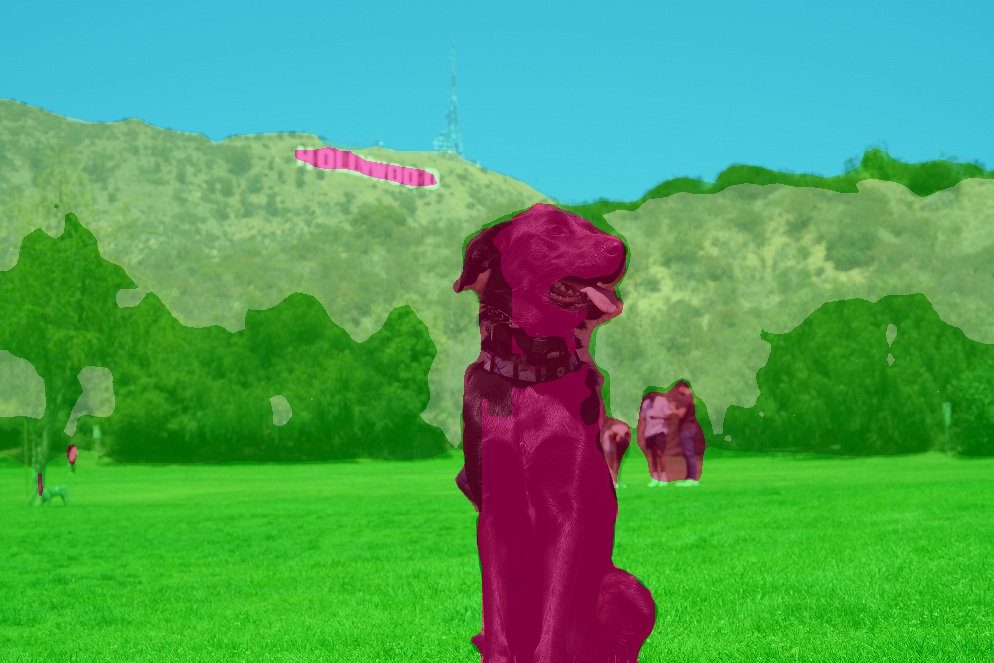

In [10]:
# combine segmentation mask with image
blended_image = apply_segmentation_mask(pil_image, original_results)

# show image with segmentation mask overlay
blended_image

We can see that model segments the image into meaningful parts.
Since we are using tiny variant of model, the result is not as good as it is with larger models, but it already shows nice segmentation performance.

## Convert Model to OpenVINO Intermediate Representation (IR)

 `mo.convert_model` function can be used for converting model using OpenVINO Model Optimizer.
 The function returns instance of OpenVINO Model class, which is ready to use in Python interface but can also be serialized to OpenVINO IR format for future execution.

In [11]:
from openvino.tools import mo
from openvino.runtime import serialize
# get input sizes from config file
batch_size = 2
channels = 3
image_size = config["dataset_kwargs"]["image_size"]

# make dummy input with correct shapes obtained from config file
dummy_input = torch.randn(batch_size, channels, image_size, image_size)

ov_model = mo.convert_model(pytorch_model, example_input=dummy_input)
serialize(ov_model, MODEL_DIR / "segmenter.xml")

/home/ea/work/openvino_notebooks/notebooks/204-segmenter-semantic-segmentation/./segmenter/segm/model/utils.py:69: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if H % patch_size > 0:
/home/ea/work/openvino_notebooks/notebooks/204-segmenter-semantic-segmentation/./segmenter/segm/model/utils.py:71: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if W % patch_size > 0:
/home/ea/work/openvino_notebooks/notebooks/204-segmenter-semantic-segmentation/./segmenter/segm/model/vit.py:122: TracerWarning: Converting a tensor to a Python boolean might cause the trace

## Verify converted model inference

To test that model was successfully converted, we can use same inference function from original repository, but we need to make custom class.

`SegmenterOV` class contains OpenVINO model, with all attributes and methods required by inference function.
This way we don't need to write any additional custom code required to process input.

In [12]:
from openvino.runtime import Core


class SegmenterOV:
    """
    Class containing OpenVINO model with all attributes required to work with inference function.

    :param model: compiled OpenVINO model
    :type model: CompiledModel
    :param output_blob: output blob used in inference
    :type output_blob: ConstOutput
    :param config: config file containing data about model and its requirements
    :type config: dict
    :param n_cls: number of classes to be predicted
    :type n_cls: int
    :param normalization:
    :type normalization: dict

    """

    def __init__(self, model_path: Path, device:str = "CPU"):
        """
        Constructor method.
        Initializes OpenVINO model and sets all required attributes

        :param model_path: path to model's .xml file, also containing variant.yml
        :param device: device string for selecting inference device
        """
        # init OpenVino core
        core = Core()
        # read model
        model_xml = core.read_model(model_path)
        self.model = core.compile_model(model_xml, device)
        self.output_blob = self.model.output(0)

        # load model configs
        variant_path = Path(model_path).parent / "variant.yml"
        with open(variant_path, "r") as f:
            self.config = yaml.load(f, Loader=yaml.FullLoader)

        # load normalization specs from config
        normalization_name = self.config["dataset_kwargs"]["normalization"]
        self.normalization = STATS[normalization_name]

        # load number of classes from config
        self.n_cls = self.config["net_kwargs"]["n_cls"]

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        """
        Perform inference on data and return the result in Tensor format

        :param data: input data to model
        :return: data inferred by model
        """
        return torch.from_numpy(self.model(data)[self.output_blob])

Now that we have created `SegmenterOV` helper class, we can use it in inference function.

### Select inference device

select device from dropdown list for running inference using OpenVINO

In [13]:
import ipywidgets as widgets

core = Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [14]:
# load model into SegmenterOV class
model = SegmenterOV(MODEL_DIR / "segmenter.xml", device.value)

In [15]:
# perform inference with same function as in case of PyTorch model from repository
results = inference(model=model,
                    ims=[image],
                    ims_metas=[im_meta],
                    ori_shape=image.shape[2:4],
                    window_size=model.config["inference_kwargs"]["window_size"],
                    window_stride=model.config["inference_kwargs"]["window_stride"],
                    batch_size=2)

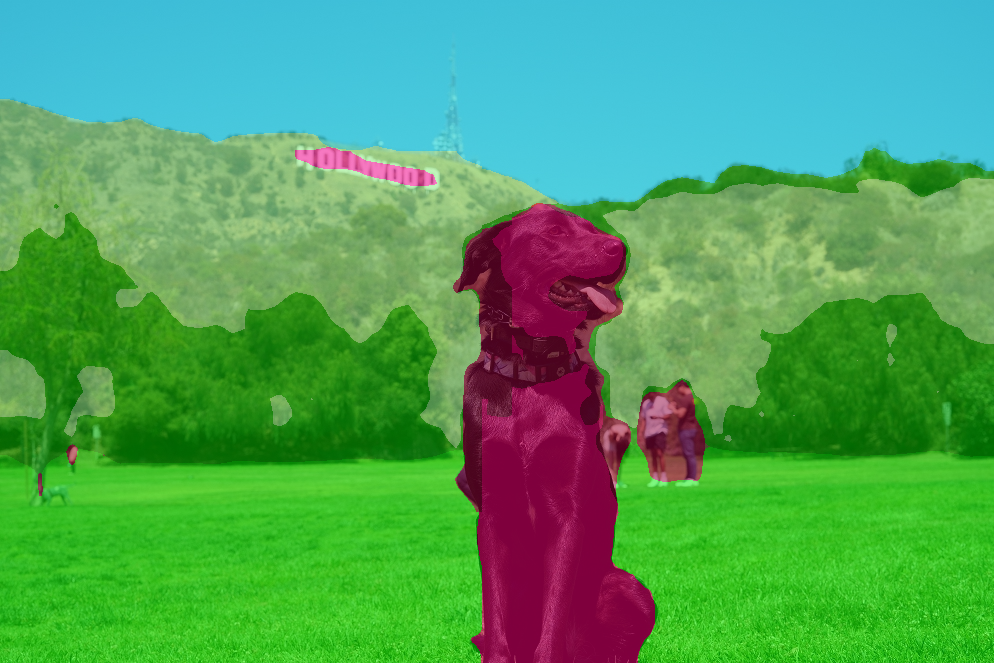

In [16]:
# combine segmentation mask with image
converted_blend = apply_segmentation_mask(pil_image, results)

# show image with segmentation mask overlay
converted_blend

As we can see, we get the same results as with original model.

## Benchmarking performance of converted model

Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2023.0/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance of the model.

> NOTE: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

> Keep in mind that the authors of original paper used V100 GPU, which is significantly more powerful than the CPU used to obtain the following throughput. Therefore, FPS can't be compared directly.

In [17]:
device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [19]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m ./model/segmenter.xml -d $device.value -api async -shape "[1,3,512,512]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.1.0-11420-54e969012d5
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2023.1.0-11420-54e969012d5
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 30.09 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     im (node: im) : f32 / [...] / [?,?,?,?]
[ INFO ] Model outputs:
[ INFO ]     y (node: aten::upsample_bilinear2d/Interpolate) : f32 / [...] / [?,?,?,?]
[Step 5/11] Resizing model to match image sizes and given